In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import nlsa.kernels as knl
import nlsa.function_algebra2 as fun
import nlsa.jax.vector_algebra as vec
import numpy as np
import os
import seaborn as sns
import time
from diffrax import Dopri5, ODETerm, PIDController, SaveAt, diffeqsolve
from functools import partial
from ipywidgets import fixed, interact, IntSlider
from jax import Array, grad, jit, jvp, vmap
from jax.sharding import Mesh, NamedSharding, PartitionSpec
from jaxlib.xla_extension import Device
from math import sqrt
from more_itertools import first, last, take
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from nlsa.abstract_algebra2 import FromScalarField, compose_by, conjugate_by, \
    multiply_by, normalize, smultiply_by
from nlsa.dynamics import orbit, semigroup
from nlsa.function_algebra2 import FunctionSpace, compose, compose2, \
    make_constant
from nlsa.jax.dynamics import flow, from_autonomous, make_l63_vector_field
from nlsa.jax.matrix_algebra import MatrixAlgebra, MatrixSpace
from nlsa.jax.vector_algebra import MeasureFnAlgebra, ScalarField, \
    VectorAlgebra 
from nlsa.jax.utils import make_batched
from nlsa.utils import swap_args
from pathlib import Path
from scipy.sparse.linalg import LinearOperator, svds
from scipy.linalg import eigh
from typing import Callable, Literal, Optional, TypeVar

In [2]:
IDX_CPU: int = 0
IDX_GPU: tuple[int] = (0, 1, 2, 3)
# IDX_GPU: tuple[int] = (1,)
XLA_MEM_FRACTION: Optional[float] = '.97'
FP: Literal['f32', 'f64'] = 'f64'
SORT_BY: Literal['energy', 'frequency'] = 'energy'
FIG_DIR = 'l63'
SAVE_FIGS: bool = True
SAVE_KERNEL_EIGS: bool = True
SAVE_TRAIN_TEST_DATA: bool = True
TRAIN_TEST_DATA_MODE: Literal['calc', 'read'] = 'calc'
KERNEL_EIGS_MODE: Literal['calc', 'read'] = 'calc'
DPI: int = 300
SCL: float = 0.65

if XLA_MEM_FRACTION is not None:
    # This has to come first in order to take effect.
    os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = XLA_MEM_FRACTION

device_cpu = jax.devices("cpu")[IDX_CPU]
# devices = [jax.devices('gpu')[i] for i in IDX_GPU]

match FP:
    case 'f64':
        jax.config.update("jax_enable_x64", True)
        r_dtype = jnp.float64
        c_dtype = jnp.complex128
    case 'f32':
        r_dtype = jnp.float32
        c_dtype = jnp.complex64

In [3]:
A = Array  # matrix 
A_ = Array  # sharded matrix
R = Array  # real scalar
Rm = Array  # m-dimensional real vector
X = Array  # state vector
TX = Array # tangent vector
Xs = Array  # collection of state vectors
Xs_ = Array  # sharded collection of state vectors
V = Array  # observable vector  
V_ = Array  # sharded observable vector
Vs = Array  # collection of observable vectors
Vs_ = Array  # sharded collection of observable vectors
K = r_dtype | c_dtype  # type of scalars
Ks = Array  # collection of scalars
S = TypeVar('S')
T = TypeVar('T')
F = Callable[[S], T]  # alias for univariate function

Alpha = Literal['0', '0.5', '1']  # diffusion maps parameters

In [4]:
import jax
import jax.numpy as jnp
from functools import partial

# Assuming Device is properly defined
devices = [jax.devices('cpu')[0]]  # Example list of CPU devices
device_cpu = jax.devices('cpu')[0]  # Single CPU device

def make_shard(devices):
    """Make function to shard array across devices."""
    def shard(a):
        split_arrays = jnp.split(a, len(devices))
        print("Shape of each sharded array:", [arr.shape for arr in split_arrays])
        return jax.device_put_sharded(split_arrays, devices)
    return shard

def make_unshard(device):
    """Make function to concatenate sharded array to a single device."""
    def unshard(a_):
        concatenated_array = jnp.concatenate(a_)
        print("Shape of unsharded array:", concatenated_array.shape)
        return jax.device_put(concatenated_array, device)
    return unshard

# Example usage
shard = make_shard(devices)
unshard = make_unshard(device_cpu)

# Assume 'fun' is properly defined
smap = conjugate_by(fun, unshard, fun, shard)
to_cpu = partial(jax.device_put, device=device_cpu)
jvmap = compose(jit, vmap)
jvvmap = compose(jit, compose(vmap, vmap))

# Example array
a = jnp.arange(16)
sharded_a = shard(a)
unsharded_a = unshard(sharded_a)

print("Original array shape:", a.shape)
print("Sharded array:", sharded_a)
print("Unsharded array:", unsharded_a)


Shape of each sharded array: [(16,)]
Shape of unsharded array: (16,)
Original array shape: (16,)
Sharded array: [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]]
Unsharded array: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [5]:
def directional_derivative(v: F[X, TX], f: F[X, R]) -> F[X, R]:
    """Directional derivative with respect to vector field."""
    def g(x: X) -> R:
        _, gx = jvp(f, (x,), (v(x),))
        return gx
    return g

In [6]:

def make_kuramoto_vector_field(omega: jnp.ndarray, K: float, A: jnp.ndarray) -> Callable[[jnp.ndarray], jnp.ndarray]:
    """Make vector field for the Kuramoto model.
    
    Args:
        omega: Natural frequencies of the oscillators, shape (N,).
        K: Coupling strength.
        A: Adjacency matrix, shape (N, N).
        
    Returns:
        Vector field function taking theta (shape (N,)) and returning dtheta/dt (shape (N,)).
    """
    def vec(theta: jnp.ndarray) -> jnp.ndarray:
        vector_field = []
        # for i in range(theta.shape[0]):
        print(theta.shape)
        N = theta.shape[0]
        theta_diff = theta.reshape(1, N) - theta.reshape(N, 1) 
        sin_diff = jnp.sin(theta_diff)
        coupling = (K / N) * jnp.sum(A * sin_diff, axis=1)
        dtheta_dt = omega + coupling
        # vector_field.append(dtheta_dt)
        # np.array(vector_field)
        return dtheta_dt
    return vec

In [7]:
Train = np.load('Train.npy')
Test = np.load('Test.npy')
rho_data = np.load('rho.npy')
w_nat = np.load('w_nat.npy')
adj_matrix = np.load('adj_mat.npy')

N = 16 #osicllator
K = rho_data[0]
A = adj_matrix[1]



In [8]:
v = make_kuramoto_vector_field(w_nat,K,A)
vgrad = partial(directional_derivative, v) 

In [9]:
N = Literal[80_000]
n: N = 800
n_spin = 5000
dt = 3.0

n_tot = n_spin + n
ninv = 1.0 / n
sqrtn = sqrt(n)


xs = Train
xs_: Xs_ = shard(xs)

Shape of each sharded array: [(800, 16)]


In [10]:
dt_tst = 0.001
sim_time = 0.4
n_tst = int(sim_time / dt)
x0_tst = xs[-1]
ts_tst = jnp.arange(0, n_tst) * dt_tst
xs_tst = Test

Traced<ShapedArray(float64[0], weak_type=True)>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[], weak_type=True)>with<DynamicJaxprTrace>


BASIS FUNCTION

In [11]:
scl = ScalarField(dtype=r_dtype)
l2x: MeasureFnAlgebra[X, N, K] = \
    MeasureFnAlgebra(dim=n,
                     dtype=r_dtype,
                     unit=make_constant(shard(jnp.ones(n, dtype=r_dtype))),
                     measure=vec.counting_measure,
                     inclusion_map=vec.jeval_at(xs_, devices=devices))

Shape of each sharded array: [(800,)]


In [12]:
n_bandwidth: int = 128
log10_bandwidth_lims: tuple[float, float] = (-3.0, 3.0)

start_time = time.perf_counter()
log10_bandwidths = jnp.linspace(log10_bandwidth_lims[0],
                                log10_bandwidth_lims[1], n_bandwidth)
shape_func = partial(knl.make_exponential_rbf, scl)

def k_func(epsilon: R) -> Callable[[X, X], R]:
    return  compose(shape_func(epsilon), vec.sqeuclidean)

k_tune = jit(knl.make_tuning_objective(l2x, k_func, grad))
est_dims = jnp.array([k_tune(epsilon) for epsilon in log10_bandwidths])
i_opt = jnp.argmax(est_dims)
bandwidth_opt = 10.0 ** log10_bandwidths[i_opt]
dim = est_dims[i_opt]
end_time = time.perf_counter()
print(f"Kernel tuning took {end_time - start_time:.3e} s")
print(f"Optimal bandwidth index: {i_opt}")
print(f"Optimal bandwidth: {bandwidth_opt:.3e}")
print(f"Estimated dimension: {dim:.3e}")

Traced<ShapedArray(float64[1])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[127])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[1,800])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[1,800])>with<DynamicJaxprTrace>
Traced<ShapedArray(int64[], weak_type=True)>with<DynamicJaxprTrace>
Traced<ShapedArray(int64[], weak_type=True)>with<DynamicJaxprTrace>
Kernel tuning took 1.714e+00 s
Optimal bandwidth index: 52
Optimal bandwidth: 2.862e-01
Estimated dimension: 6.230e+00


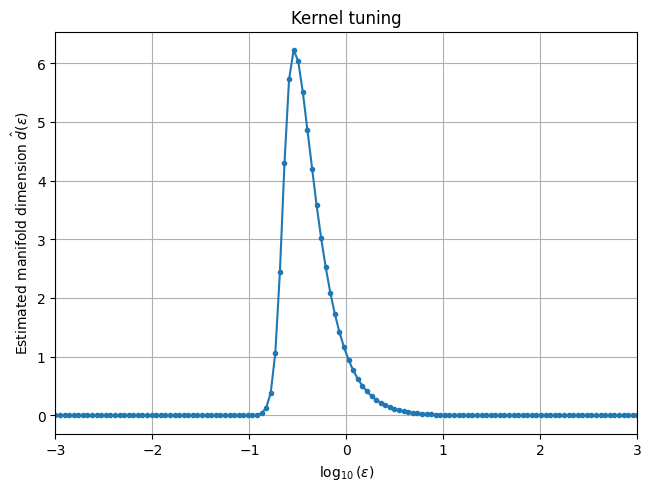

In [13]:
i_fig = 2
if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_tuning(i):
    fig, ax = plt.subplots(num=i, constrained_layout=True)
    return fig, ax


def plotfig_tuning(figspecs):
    fig, ax = figspecs
    ax.plot(log10_bandwidths, est_dims, '.-')
    ax.set_xlim(log10_bandwidth_lims)
    ax.grid()
    ax.set_xlabel(r'$\log_{10}(\epsilon)$')
    ax.set_ylabel(r'Estimated manifold dimension $\hat d(\epsilon)$')
    ax.set_title('Kernel tuning')


plotfig_tuning(initfig_tuning(i_fig))

In [14]:
bandwidth_scl = 2.0  # 1.0

bandwidth = bandwidth_scl * bandwidth_opt
rbf: Callable[[X, X], R] = knl.make_exponential_rbf(scl, bandwidth)
k: Callable[[X, X], R] = compose(rbf, vec.sqeuclidean)
p: Callable[[X, X], R] = knl.dm_normalize(l2x, '1', k)
t_heat = bandwidth**2 / 4.0
fourpi = 4.0 * jnp.pi
vol = knl.riemannian_vol(l2x, p, dim, t_heat, fourpi)
bandwidth_func: F[X, R] = knl.make_bandwidth_function(l2x, k, dim, vol)
scaled_sqeuclidean = knl.make_scaled_sqdist(l2x, vec.sqeuclidean,
                                            bandwidth_func)
print(f"Estimated volume: {vol:.3e}")

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Estimated volume: 5.887e+00


In [15]:
make_shape_func = partial(knl.make_exponential_rbf, scl)


def k_vb_func(epsilon: R) -> Callable[[X, X], R]:
    return compose(make_shape_func(epsilon), scaled_sqeuclidean)


start_time = time.perf_counter()
k_vb_tune = jit(knl.make_tuning_objective(l2x, k_vb_func, grad))
est_vb_dims = jnp.array([k_vb_tune(epsilon)
                         for epsilon in log10_bandwidths])
i_opt_vb = jnp.argmax(est_vb_dims)
vb_bandwidth_opt = 10. ** log10_bandwidths[i_opt_vb]
end_time = time.perf_counter()
print(f"VB kernel tuning took {end_time - start_time:.3e} s")
print(f"Optimal bandwidth index: {i_opt_vb}")
print(f"Optimal bandwidth: {vb_bandwidth_opt:.3e}")
print(f"Estimated dimension: {est_vb_dims[i_opt_vb]:.3e}")

VB kernel tuning took 2.000e+00 s
Optimal bandwidth index: 59
Optimal bandwidth: 6.129e-01
Estimated dimension: 6.188e+00


In [16]:
vb_bandwidth_scl = 1.0

vb_bandwidth = vb_bandwidth_scl * vb_bandwidth_opt
rbf_vb: Callable[[X, X], R] = knl.make_exponential_rbf(scl, vb_bandwidth)
k_vb: Callable[[X, X], R] = compose(rbf_vb, scaled_sqeuclidean)
k_bs: Callable[[X, X], R] = knl.bs_normalize(l2x, k_vb)
k_bs_op: Callable[[V], F[X, R]] = knl.make_integral_operator(l2x, k_bs)
g_bs_op: F[V, V] = compose(l2x.incl, k_bs_op)
k_bs_transp = swap_args(k_bs)
k_bs_transp_op = knl.make_integral_operator(l2x, k_bs_transp)
g_bs_transp_op = compose(l2x.incl, k_bs_transp_op)
j_bs_op = jit(g_bs_op)
js_bs_op = jit(vmap(g_bs_op, in_axes=-1, out_axes=-1))
j_bs_transp_op = jit(g_bs_transp_op)
js_bs_transp_op = jit(vmap(g_bs_transp_op, in_axes=-1, out_axes=-1))

In [17]:
eigs_batch_size = 4

make_matmat = compose(partial(make_batched, max_batch_size=eigs_batch_size,
                              in_axis=1),
                      smap)
a_bs = LinearOperator(shape=(n, n), dtype=r_dtype, 
                      matvec=smap(j_bs_op),
                      matmat=make_matmat(js_bs_op),
                      rmatvec=smap(j_bs_transp_op),
                      rmatmat=make_matmat(js_bs_transp_op))

In [18]:
num_eigs: int = 120

match KERNEL_EIGS_MODE:
    case 'calc':
        start_time = time.perf_counter()
        unsorted_us, unsorted_sigmas, unsorted_vhs = svds(a_bs, num_eigs)
        end_time = time.perf_counter()
        print(f'SVD took {end_time - start_time:.3e} s')

        if SAVE_KERNEL_EIGS:
            fnames = [f'dt{dt:.2f}',
                      f'n{n}',
                      'eigs']
            fname = '_'.join(fnames) + '.npz'
            pth = Path('data') / FIG_DIR / FP / fname
            pth.parent.mkdir(parents=True, exist_ok=True)
            np.savez(pth,
                     unsorted_us=unsorted_us,
                     unsorted_sigmas=unsorted_sigmas,
                     unsorted_vhs=unsorted_vhs)
            print("Kernel eigenvalue/eigenfunction data saved.")

    case 'read':
        fnames = [f'dt{dt:.2f}',
                  f'n{n}',
                  'eigs']
        fname = '_'.join(fnames) + '.npz'
        pth = Path('data') / FIG_DIR / FP / fname
        kernel_eigs = np.load(pth)
        unsorted_us = kernel_eigs['unsorted_us']
        unsorted_sigmas = kernel_eigs['unsorted_sigmas'] 
        unsorted_vhs = kernel_eigs['unsorted_vhs']
        del(kernel_eigs)

1
2
3
4
5
Shape of each sharded array: [(800,)]
Shape of unsharded array: (800,)
Shape of each sharded array: [(800,)]
Shape of unsharded array: (800,)
Shape of each sharded array: [(800,)]
Shape of unsharded array: (800,)
Shape of each sharded array: [(800,)]
Shape of unsharded array: (800,)
Shape of each sharded array: [(800,)]
Shape of unsharded array: (800,)
Shape of each sharded array: [(800,)]
Shape of unsharded array: (800,)
Shape of each sharded array: [(800,)]
Shape of unsharded array: (800,)
Shape of each sharded array: [(800,)]
Shape of unsharded array: (800,)
Shape of each sharded array: [(800,)]
Shape of unsharded array: (800,)
Shape of each sharded array: [(800,)]
Shape of unsharded array: (800,)
Shape of each sharded array: [(800,)]
Shape of unsharded array: (800,)
Shape of each sharded array: [(800,)]
Shape of unsharded array: (800,)
Shape of each sharded array: [(800,)]
Shape of unsharded array: (800,)
Shape of each sharded array: [(800,)]
Shape of unsharded array: (80

In [19]:
num_eigs_l = 100

cl = VectorAlgebra(dim=num_eigs_l, dtype=c_dtype)
normalize_cl = jit(vmap(partial(normalize, cl), in_axes=1, out_axes=1))
mat_l2x_cl = MatrixSpace(hilb_in=cl, hilb_out=l2x, dtype=r_dtype)
normalize_l2x = jit(vmap(partial(normalize, l2x), in_axes=-1, out_axes=-1))

In [20]:
isort = jnp.argsort(unsorted_sigmas)
sigmas_all = unsorted_sigmas[isort[::-1]]
lambs_all = sigmas_all ** 2
etas_all = (1.0 / lambs_all - 1.0) / (1.0 / lambs_all[1] - 1.0)
us_all = unsorted_us[:, isort[::-1]]
vhs_all = unsorted_vhs[isort[::-1], :]

with jax.default_device(device_cpu):
    sigmas = jnp.array(sigmas_all[1 : (num_eigs_l+1)])
    lambs = jnp.array(lambs_all[1 : (num_eigs_l+1)])
    etas = jnp.array(etas_all[1 : (num_eigs_l+1)])
    phis = us_all[:, 1 : (num_eigs_l+1)] * sqrtn
    gammas = vhs_all[1 : (num_eigs_l+1), :].T * sqrtn

print('First 5 NLSA eigevalues:')
print(lambs[0:5])
print('First 5 Laplacian eigenvalues:')
print(etas[0:5])

First 5 NLSA eigevalues:
[0.61552292 0.57525583 0.53511396 0.52444429 0.52013285]
First 5 Laplacian eigenvalues:
[1.         1.18206181 1.39082986 1.45169648 1.47700007]


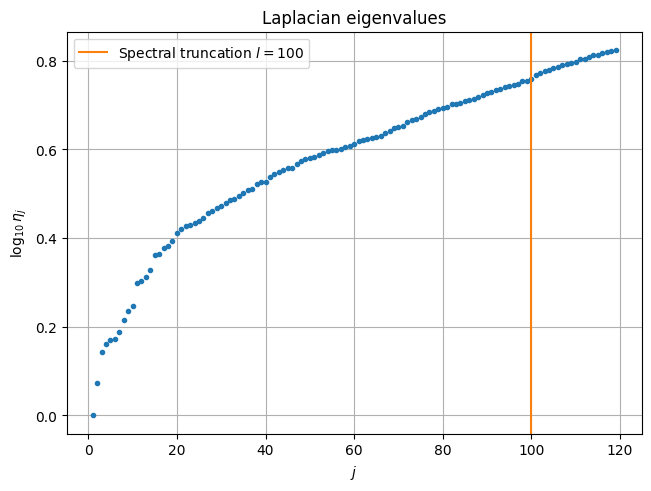

In [21]:
i_fig = 5
n_eig_plt = num_eigs

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_lapleigs(i):
    fig, ax = plt.subplots(num=i, constrained_layout=True)
    return fig, ax


def plotfig_lapleigs(figspecs):
    fig, ax = figspecs
    ax.cla()
    ax.plot(jnp.arange(1, n_eig_plt), jnp.log10(etas_all[1:]), '.')
    ax.axvline(num_eigs_l, color=u'#ff7f0e',
               label=f'Spectral truncation $l = {num_eigs_l}$')
    ax.grid()
    ax.legend()
    ax.set_xlabel('$j$')
    ax.set_ylabel(r'$\log_{10}\eta_j$')
    ax.set_title('Laplacian eigenvalues')


plotfig_lapleigs(initfig_lapleigs(i_fig))

In [22]:
to_rkhs = k_bs_op
to_l2x = compose(l2x.incl, to_rkhs)
to_vgrad = compose(vgrad, to_rkhs)
to_vgrad_l2x = compose(l2x.incl, to_vgrad)

In [23]:
tau = 1.0E-5

with jax.default_device(device_cpu):
    lambs_tau_all = jnp.exp(-0.5 * tau * etas_all)
    lambs_tau = lambs_tau_all[1 : (num_eigs_l+1)]

# rkhs_synth = compose(to_rkhs,
#                     compose(shard,
#                             partial(mat_l2x_cm.app,
#                                     gammas / sigmas * lambs_tau)))
rkhs_synth = compose(to_rkhs,
                     compose(shard,
                             partial(mat_l2x_cl.app, gammas)))

In [24]:
phi_batch_size = 1
to_vgrad_l2x_batched = make_batched(smap(jit(vmap(to_vgrad_l2x,
                                                  in_axes=-1, out_axes=-1))),
                                    max_batch_size=phi_batch_size,
                                    in_axis=1)

In [25]:
start_time = time.perf_counter()
vgrad_phis = to_vgrad_l2x_batched(gammas / sigmas)
end_time = time.perf_counter()
print(f'Computation of {num_eigs_l} eigenfunction gradients on training data took '
      f'{end_time - start_time:.3e} s')

Shape of each sharded array: [(800, 1)]
(16,)
Traced<ShapedArray(float64[1,16])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[16,16])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[1])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[16])>with<DynamicJaxprTrace>
Shape of unsharded array: (800, 1)
Shape of each sharded array: [(800, 1)]
Shape of unsharded array: (800, 1)
Shape of each sharded array: [(800, 1)]
Shape of unsharded array: (800, 1)
Shape of each sharded array: [(800, 1)]
Shape of unsharded array: (800, 1)
Shape of each sharded array: [(800, 1)]
Shape of unsharded array: (800, 1)
Shape of each sharded array: [(800, 1)]
Shape of unsharded array: (800, 1)
Shape of each sharded array: [(800, 1)]
Shape of unsharded array: (800, 1)
Shape of each sharded array: [(800, 1)]
Shape of unsharded array: (800, 1)
Shape of each sharded array: [(800, 1)]
Shape of unsharded array: (800, 1)
Shape of each sharded array: [(800, 1)]
Shape of unsharded array: (800, 1)
Shape of each sh

In [26]:
res_z = 0.1

with jax.default_device(device_cpu):
    start_time = time.perf_counter()
    v_mat = phis.T @ vgrad_phis * ninv
    a_mat = 0.5*(v_mat - v_mat.T)/1j
    a_tau_mat = lambs_tau[:, np.newaxis] * a_mat * lambs_tau
    c_mat = res_z * phis - vgrad_phis
    b_mat = c_mat.T @ c_mat * ninv
    end_time = time.perf_counter()
    
print(f'Computation of generalized eigenvalue problem matrices took '
      f'{end_time - start_time:.3e} s')

Traced<ShapedArray(float64[100,100])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[100,100])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[100,1])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[100,100])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[100,100])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[1,100])>with<DynamicJaxprTrace>
Computation of generalized eigenvalue problem matrices took 2.395e-01 s


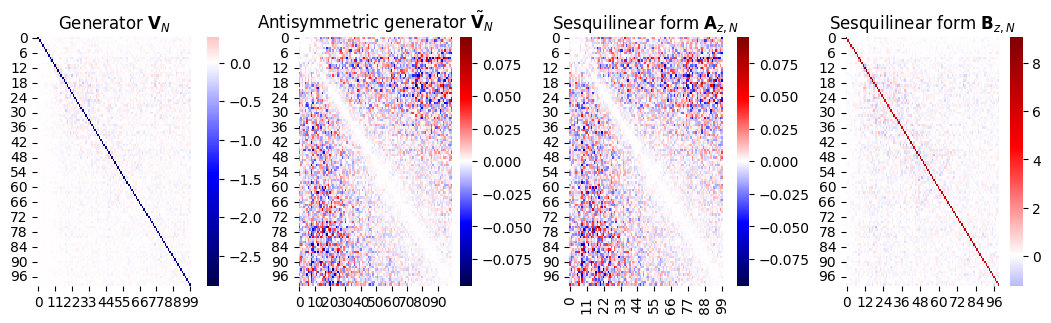

In [27]:
i_fig = 11

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_gev_mats(i):
    fig, axs = plt.subplots(1, 4, num=i_fig, figsize=(16.0*SCL, 4.8*SCL),
                            constrained_layout=True)
    return fig, axs


def plotfig_gev_mats(figspecs, save_fig=False):
    fig, axs = figspecs
    axv, axa, axt, axm = axs
    [ax.cla() for ax in axs] 
    sns.heatmap(v_mat, ax=axv, cmap='seismic', center=0.0, robust=False)
    axv.set_title(r"Generator $\mathbf{V}_N$")
    sns.heatmap(a_mat.imag, ax=axa, cmap='seismic', center=0.0, robust=False)
    axa.set_title(r"Antisymmetric generator $\mathbf{\tilde{V}}_N$")
    sns.heatmap(a_tau_mat.imag, ax=axt, cmap='seismic', center=0.0, robust=False)
    axt.set_title(r"Sesquilinear form $\mathbf{A}_{z,N}$")
    sns.heatmap(b_mat, ax=axm, cmap='seismic', center=0.0, robust=False)
    axm.set_title(r"Sesquilinear form $\mathbf{B}_{z,N}$")

    if save_fig:        
        fnames = [f'dt{dt:.2f}',
                  f'n{n}',
                  f'l{num_eigs_l}',
                  f'z{res_z:.2f}',
                  f'tau{tau:.2e}',
                  'gev']
        fname = '_'.join(fnames) + '.png'
        pth = Path('figs') / FIG_DIR / FP / fname
        pth.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(pth, bbox_inches='tight', dpi=DPI)
        
plotfig_gev_mats(initfig_gev_mats(i_fig), SAVE_FIGS)

In [28]:
start_time = time.perf_counter()
unsorted_gevals, unsorted_gevecs = eigh(a_tau_mat, b_mat)
end_time = time.perf_counter()
print(f'Generalized eigenvalue problem took {end_time - start_time:.3e} s')

Generalized eigenvalue problem took 1.132e-01 s


In [29]:
with jax.default_device(device_cpu):
    unsorted_gevecs = normalize_cl(unsorted_gevecs)
    unsorted_engys = jnp.sum(jnp.abs(unsorted_gevecs)**2 \
                             / lambs[:num_eigs_l, jnp.newaxis],
                             axis=0) - 1.0

    match SORT_BY:
        case 'frequency':
            isort_gen = jnp.argsort(jnp.abs(unsorted_gevals.real))[::-1]
        case 'energy':
            isort_gen = jnp.argsort(unsorted_engys)
    
    gevals = jnp.array(unsorted_gevals[isort_gen])
    res_evals = gevals.real
    eigenfreqs = (1.0 + jnp.sqrt(1.0 - 4.0 * res_z**2 * res_evals**2)) \
        / (2.0 * res_evals)
    engys = unsorted_engys[isort_gen]
    gevecs = normalize_cl(unsorted_gevecs[:, isort_gen])

    
n_print = 70 # 201

with jnp.printoptions(precision=3, suppress=True):
    print('Eigenfrequencies and Dirichlet energies:')
    print(jnp.hstack((jnp.arange(n_print)[:, jnp.newaxis],
                      eigenfreqs[:n_print, jnp.newaxis],
                      engys[:n_print, jnp.newaxis])))

Traced<ShapedArray(complex128[100])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[100])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[100])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[100])>with<DynamicJaxprTrace>
Eigenfrequencies and Dirichlet energies:
[[    0.      -10.344     2.08 ]
 [    1.       10.344     2.08 ]
 [    2.      -15.305     2.083]
 [    3.       15.305     2.083]
 [    4.      -11.776     2.093]
 [    5.       11.776     2.093]
 [    6.       11.128     2.102]
 [    7.      -11.128     2.102]
 [    8.      -77.534     2.116]
 [    9.       77.534     2.116]
 [   10.      -27.96      2.129]
 [   11.       27.96      2.129]
 [   12.       25.192     2.141]
 [   13.      -25.192     2.141]
 [   14.       12.851     2.155]
 [   15.      -12.851     2.155]
 [   16.      -22.472     2.156]
 [   17.       22.472     2.156]
 [   18.       13

In [31]:
num_zetas = n_print

with jax.default_device(device_cpu):
    start_time = time.perf_counter()
    zetas_l2 = normalize_l2x(c_mat @ gevecs[:, :num_zetas]) * sqrtn
    zetas_coeffs = phis.T @ zetas_l2 * ninv
    zetas_l2 = phis  @ zetas_coeffs
    #zetas_rkhs = (phis * lambs_tau) @ zetas_coeffs
    zetas_rkhs = (phis * sigmas) @ zetas_coeffs
    end_time = time.perf_counter()
    
print(f'Computation of {num_zetas} generator eigenvectors on training data took '
      f'{end_time - start_time:.3e} s')

Traced<ShapedArray(complex128[800])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[800])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[800])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[800,70])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[100,70])>with<DynamicJaxprTrace>
Traced<ShapedArray(complex128[])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[800,100])>with<DynamicJaxprTrace>
Traced<ShapedArray(float64[1,100])>with<DynamicJaxprTrace>
Computation of 70 generator eigenvectors on training data took 1.936e-01 s
